# Introduction

In this notebook, we walk through a classification example using K Nearest Neighbors (KNN). This notebook does binary classification in R.

Recall how K nearest neighbors works: For each data point we want to classify, we find its nearest neighbors (by distance) in the training set. Then, we classify the point based on how many of its neighbors belong to each class.  

We limit ourselves to studying binary classification, i.e. each data point can be classified as either a $0$ or a $1$. 


KNN is parametrized by the following values:
1. $K$: The number of neighbors we consider for the new data point.
1. $L$: The number of neighbors that need to be a $1$ in order to classify the point as so. In other words, when $L = K/2$, we are taking a majority vote on the neighbors in order to classify the data points. (For now, ignore rounding issues with K, and whether a majority means exactly half or slightly more than half)
1. $N$: The number of points in our training dataset. 

How to read this notebook:
1. We assume you have watched all the modules in Lecture 3 where the KNN classifier is discussed.
1. We include the code for your information, but do not expect you to understand what each line is doing if you've never seen R code before. If you wish, you may skip reading any of the code boxes, and just read the text and the plots that are outputted. Similarly, we provide this notebook both in pdf format, and in a IPython Notebook that you can run yourself.
1. In each plot, we will trade off Accuracy (or some other metric) with a KNN parameter. We will also show the difference between _test_ and _train_ performance.

By the end of this notebook, you will observe and should be able to explain:
1. How performance changes with the size of the training dataset. 
1. Why there is a difference between test and training error.
1. How $K$ relates to _overfitting_ and _underfitting_. 
1. How $L$ changes the ratio of _false positives_ and _false negatives_, and why $L = K/2$ maximizes accuracy.


# Setup and installation

If you wish to run this notebook, you'll need to install Jupyter Notebook from https://jupyter.org/, the R programming language, and the R kernel for Jupyter Notebooks from https://irkernel.github.io/installation/. 

This specific notebooks also requires several packages. To install packages in R, use install.packages as we do in the next cell. We have the code commented out at the moment so we do not overwrite packages that you already have installed.

In [1]:
#install.packages('plyr')
#install.packages('ggplot2')
#install.packages('class')
#install.packages('Hmisc')
# install.packages('ggrepel')

Just for display purposes in this notebook, we suppress all warnings. If you are running this notebook yourself, you may find it useful to remove this line.

In [2]:
options(warn=-1)

After installing the necessary packages, we now load them. 

In [ ]:
library(plyr)
library(ggplot2)
library(class)
library(Hmisc)
library(ggrepel)

# Main Code

## Helper functions

The following functions sample data, which we will use to train and test our classifier. The first samples our X data, i.e. our covariates or features. The second function samples a response variable, i.e. our output, for each of the covariates. In this notebook, we assume the following _population model_:

We have two _covariates_ that are drawn from a Normal distribution with mean $0$ and variance $1$, i.e. for each data point we have $$ X_1, X_2 \sim Normal (0, 1) $$

Then, we assume that the _response_ variable is related to $X$ as follows:
$$ Y = \begin{cases} 1 & \text{with probability } \frac{c}{1+c} \\ 0 &  \text{with probability } 1 - \frac{c}{1+c}\end{cases} $$
Where $$c = e^{2 X_1 + 3 X_2}$$

This type of response is said to follow a _logistic model_. 

Note that a _Normal_ distribution, and a _logistic model_ is a particular type of random distribution that is typically assumed for covariate distributions in data science, as they often show up in real life.

It is not necessary to understand exactly the components of this population, as long as you understand what it means to have 2 covariates, and 1 response variable. 


In [4]:
sample_data <- function(N){
    X1 = rnorm(N,0,1)
    X2 = rnorm(N,0,1)
    return (cbind(X1,X2))
}

draw_response <- function(covariates){
    pi_x <- exp(2 * covariates[,"X1"] + 3*covariates[,"X2"]) / (1 + exp( 2 * covariates[,"X1"] + 3*covariates[,"X2"]))
    Y <- rbinom(n=length(pi_x), size=1, prob=pi_x)
}

Given some predictions and the true response values, the following function calculates the accuracy, false positive rate, and false negative rate. Let $\tilde{Y_i}$ be the predicted value (by the KNN model) for the $i$th observation, and let $Y_i$ be the true response. Suppose we have $N$ such observations. Then, recall that these values are defined as follows

1. The ErrorRate, (Also called Prediction Error, or 0-1 loss) is the fraction of observations for which we classified incorrectly, and Accuracy is the fraction that we have classified correctly. Mathematically, $ErrorRate = \frac{1}{N}\sum_i^N |Y_i - \tilde{Y_i}|$, and, $Accuracy =$ 1 - ErrorRate. 
1. FalsePositiveRate = $\frac{\text{Number of observations incorrectly marked as $1$}}{\text{Total number of observations marked as $1$}}$
1. FalseNegativeRate = $\frac{\text{Number of observations incorrectly marked as $0$}}{\text{Total number of observations marked as $0$}}$

In [5]:
evaluate_predictions <- function(predictions, true_value){
#     predictions = as.numeric(levels(predictions)[predictions]) #converts from a factor to a numeric 0,1
    
    true_positives = sum((predictions == true_value) & true_value == 1)
    true_negatives = sum((predictions == true_value) & true_value == 0)
    
    false_positives = sum((predictions != true_value) & true_value == 0)
    false_negatives = sum((predictions != true_value) & true_value == 1)

    
    accuracy = (true_positives + true_negatives)/length(predictions)
    false_negative_rate = false_negatives/(false_negatives + true_negatives)
    false_positive_rate = false_positives/(false_positives + true_positives)

    return(list(Accuracy = accuracy, FPR = false_positive_rate, FNR = false_negative_rate))
}

## KNN function

The following function takes in training data, and its true responses, and makes predictions on the test data. It is parameterized by two values, $K$ and $L$. $K$ is the number of neighbors to consider, and $L$ is the number of neighbors who must be a $1$ to label a given datapoint a $1$. 

Unfortunately, R doesn't have a native KNN function that takes in a parameter like $L$, and so we use an attribute the native KNN returns indicating what percentage of a point's neighbors are of a certain type.

In [6]:
knn_with_variable_threshold <- function (K, L, train, trueresponse_train, test){
    predictions_with_majority_rule = knn(train = train, test = test, cl = trueresponse_train, k = K, l = L, prob = TRUE)
    
    #default knn returns an attribute called prob that indicates the threshold at which it holds.
    probabilities = attr(predictions_with_majority_rule, 'prob')
    
    #converts from a factor to a numeric 0,1
    predictions = as.numeric(levels(predictions_with_majority_rule)[predictions_with_majority_rule]) 

    #if predicted 1 with less than proper threshold, convert prediction to 0
    if (L/K >= .5){
        predictions = as.numeric(predictions & (probabilities > L/K))
    }
    else{     #if predicted 0 with less than proper threshold, convert prediction to 0
        predictions = 1-as.numeric((1-predictions) & (probabilities > 1-L/K))
    }

}

## Putting it together

Finally, we can write a function that takes in 3 parameters: $K$, $L$, and $N$, and then runs many simulations. In each simulation, we draw training and test data, and then evaluate the performance of the KNN algorithm. 

In [7]:
run_knn <- function(K, L, N = 500){
    
    M = 100    
    train_evals <- data.frame(Accuracy=double(),FPR=double(),FNR=double()) 
    test_evals <- data.frame(Accuracy=double(),FPR=double(),FNR=double()) 

    for (i in 1:M){
        train = sample_data(N)
        trueresponse_train = draw_response(train)
#         predictions_train = knn(train = train, test = train, cl = trueresponse_train, k = K, l = L)
        predictions_train = knn_with_variable_threshold(train = train, test = train, trueresponse_train = trueresponse_train, K = K, L = L)
        
        
        evaluations_train = evaluate_predictions(predictions_train, trueresponse_train)
        
        train_evals <- rbind(train_evals, evaluations_train)
        
        test = sample_data(N)
        trueresponse_test = draw_response(test)
#         predictions_test = knn(train = train, test = test, cl = trueresponse_train, k = K, l = L)
        predictions_test = knn_with_variable_threshold(train = train, test = test, trueresponse_train = trueresponse_train, K = K, L = L)
        
        evaluations_test = evaluate_predictions(predictions_test, trueresponse_test)
        
        test_evals <- rbind(test_evals, evaluations_test)
    }
    return(list(train = train_evals, test = test_evals))
}



# Accuracy as dataset size N varies

Here we observe what happens when we increase $N$, the size of the training and test sets, while keeping the other parameters fixed.

In [8]:
train_evals_all <- data.frame(Accuracy=double(),FPR=double(),FNR=double(), N = double())
test_evals_all <- data.frame(Accuracy=double(),FPR=double(),FNR=double(), N = double()) 

K = 100

for (N in c(8, 12, c(1:25)*20)){
    evaluations <- run_knn(N/2, N/4, N)
    evaluations$test[,'N'] = N
    evaluations$train[,'N'] = N
    train_evals_all <- rbind(train_evals_all,evaluations$train)
    test_evals_all <- rbind(test_evals_all,evaluations$test)
}

train_evals_all$Dataset = 'Train'
test_evals_all$Dataset = 'Test'

evaluations_all = rbind(train_evals_all,test_evals_all)

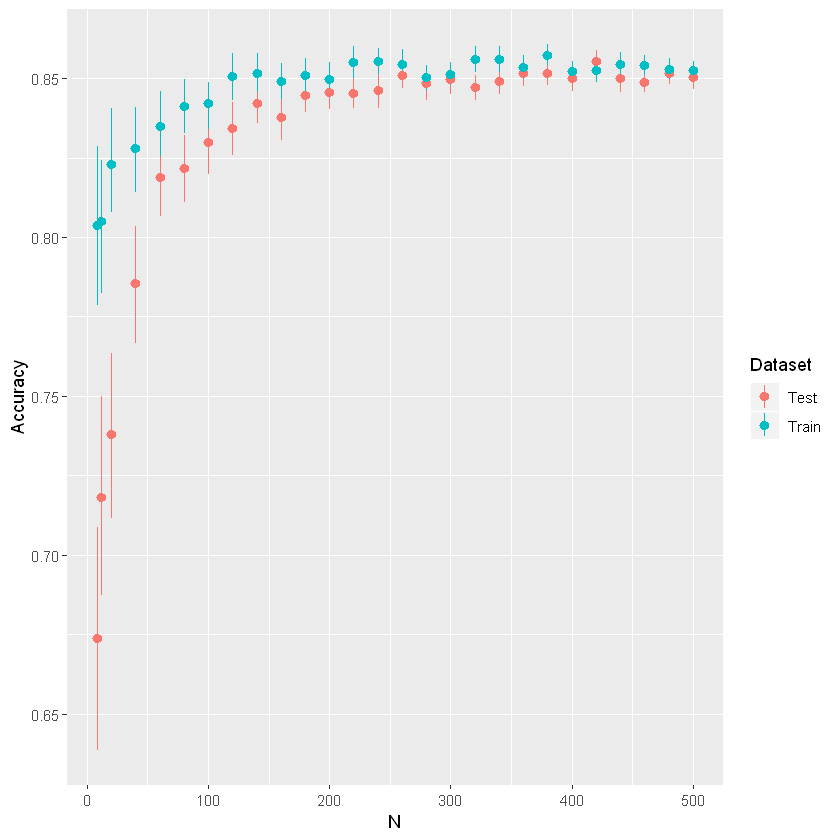

In [9]:
ggplot(data = evaluations_all) + stat_summary(fun.data=mean_cl_boot, geom="pointrange", aes(x = N, y = Accuracy, color = Dataset))

We can see that performance, as measured by accuracy, increases with $N$. Before moving on, please make sure you're able to answer the following questions:

1. Why is training accuracy consistently higher than test accuracy?
1. Why does accuracy increase with $N$?

# Accuracy as K varies

Here, we fix $N=200$ and vary $K$, fixing the threshold $L = K/2$ (i.e. majority vote). Recall that $K$ is the number of neighbors we consider for each data point. What do you expect to happen to accuracy as $K$ changes?

In [10]:
train_evals_all <- data.frame(Accuracy=double(),FPR=double(),FNR=double(), k = double())
test_evals_all <- data.frame(Accuracy=double(),FPR=double(),FNR=double(), k = double()) 

for (k in c(2, 4, c(1:40)*5)){
    evaluations <- run_knn(k, k/2, 200)
    evaluations$test[,'k'] = k
    evaluations$train[,'k'] = k
    train_evals_all <- rbind(train_evals_all,evaluations$train)
    test_evals_all <- rbind(test_evals_all,evaluations$test)
}

train_evals_all$Dataset = 'Train'
test_evals_all$Dataset = 'Test'

evaluations_all = rbind(train_evals_all,test_evals_all)

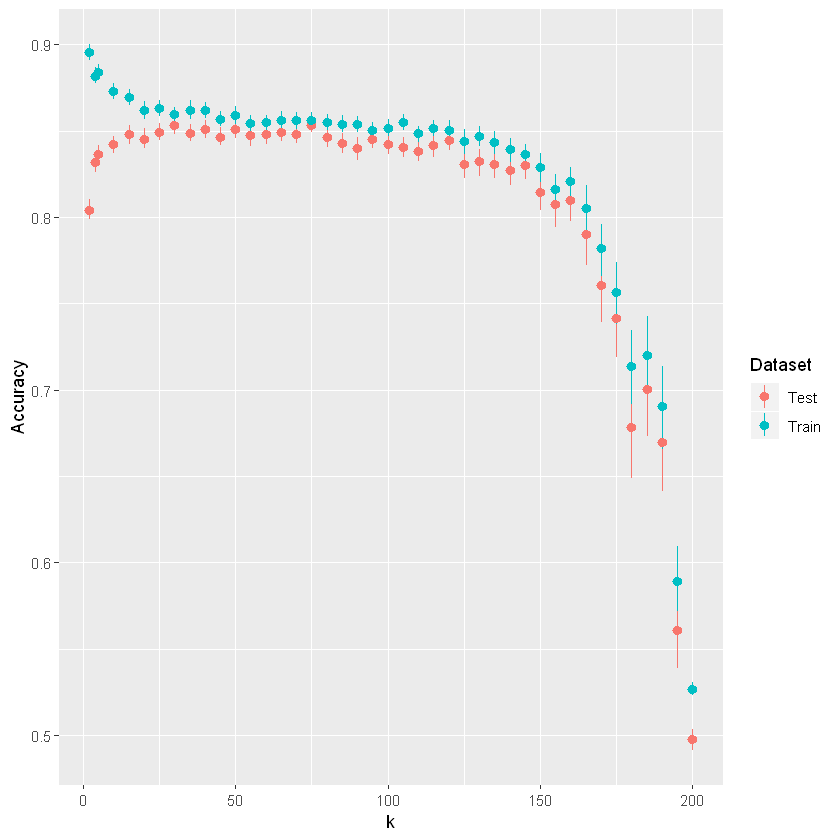

In [11]:
ggplot(data = evaluations_all) + stat_summary(fun.data=mean_cl_boot, geom="pointrange", aes(x = k, y = Accuracy, color = Dataset))

Here, we can see that test performance at first _increases_ with $K$, and then starts _decreasing_. On the other hand, the performance on the _train_ set just keeps decreasing with $K$. 

Before moving on, please ensure that you can answer the following questions:
1. What explains the pattern in the test set?
1. What explains the different pattern in the training set? (Hint: When K=1, i.e. we only look at 1 point, what happens? For a given point in the training set, what is the closest point to it that's also in the training set?).

# False positives, negatives, and accuracy as L changes

Finally, we fix $N= 200, K = 100$, and then vary $L$, the number of neighbors required to be a $1$ before we declare a point to be a $1$. Intuitively, $L$ affects performance as follows: when it is higher than $K/2$, then we require more than half of the neighbors to be a $1$ before declaring it a $1$, as opposed to less than half of its neighbors to declare it a $0$. This makes false positives rarer. 

In [12]:
train_evals_all <- data.frame(Accuracy=double(),FPR=double(),FNR=double(), l = double())
test_evals_all <- data.frame(Accuracy=double(),FPR=double(),FNR=double(), l = double()) 

for (L in c(0:20)*5){
    evaluations <- run_knn(100, L, 200)
    evaluations$test[,'L'] = L
    evaluations$train[,'L'] = L
    train_evals_all <- rbind(train_evals_all,evaluations$train)
    test_evals_all <- rbind(test_evals_all,evaluations$test)
}

train_evals_all$Dataset = 'Train'
test_evals_all$Dataset = 'Test'

evaluations_all = rbind(train_evals_all,test_evals_all)

### False Negative Rate

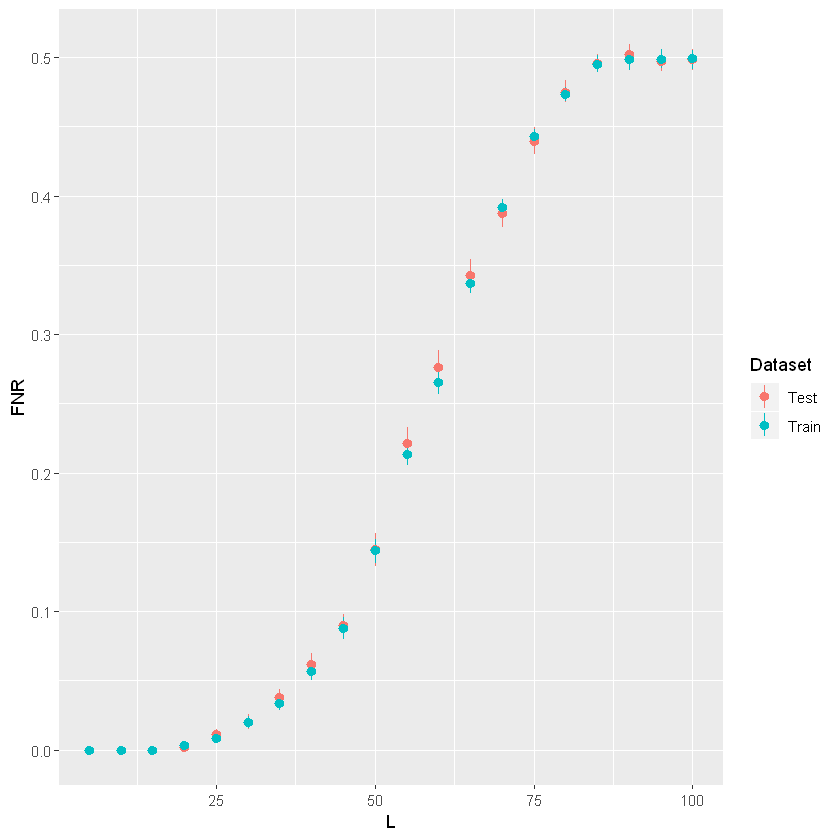

In [13]:
ggplot(data = evaluations_all) + stat_summary(fun.data=mean_cl_boot, geom="pointrange", aes(x = L, y = FNR, color = Dataset))

The above plot shows the False Negative Rate (FNR) with $L$. Before moving on, be able to answer the following:

1. Why is FNR $0$ when $L=0$?
1. Why is FNR near $.5$ when $L = K = 100$?

### False Positive Rate

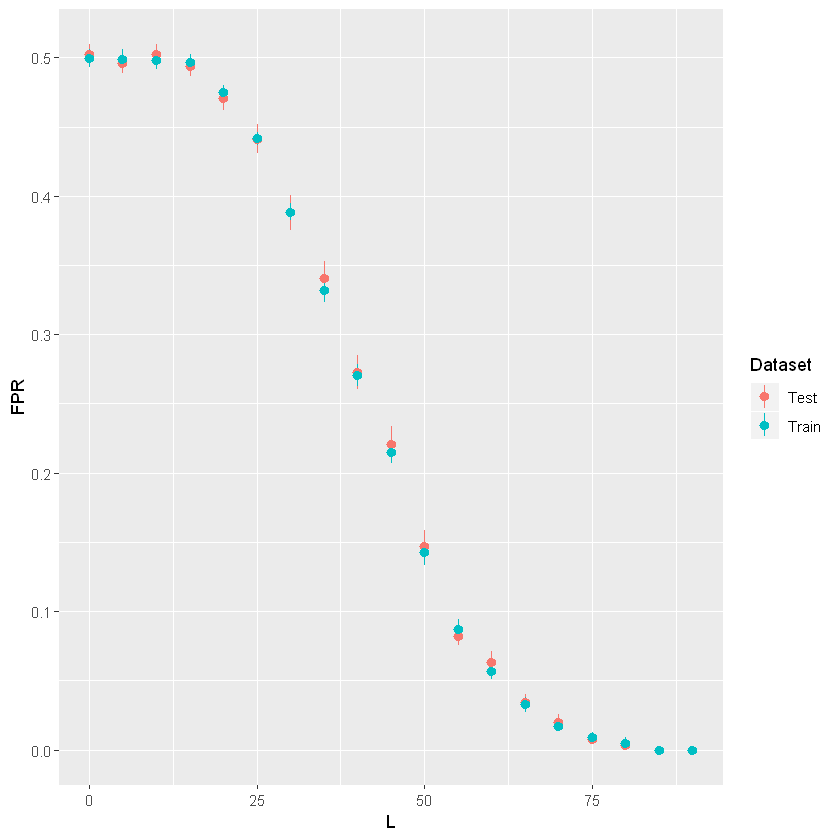

In [14]:
ggplot(data = evaluations_all) + stat_summary(fun.data=mean_cl_boot, geom="pointrange", aes(x = L, y = FPR, color = Dataset))

The above shows the False Positive Rate (FPR) as $L$ increases. Before moving on, think about why we observe the opposite behavior as we did in the FNR case.

### Trade-off between False Positive Rate and False Negative Rate

We can put the two plots above together into a single plot, and show how FNR and FPR tradeoff with one another.

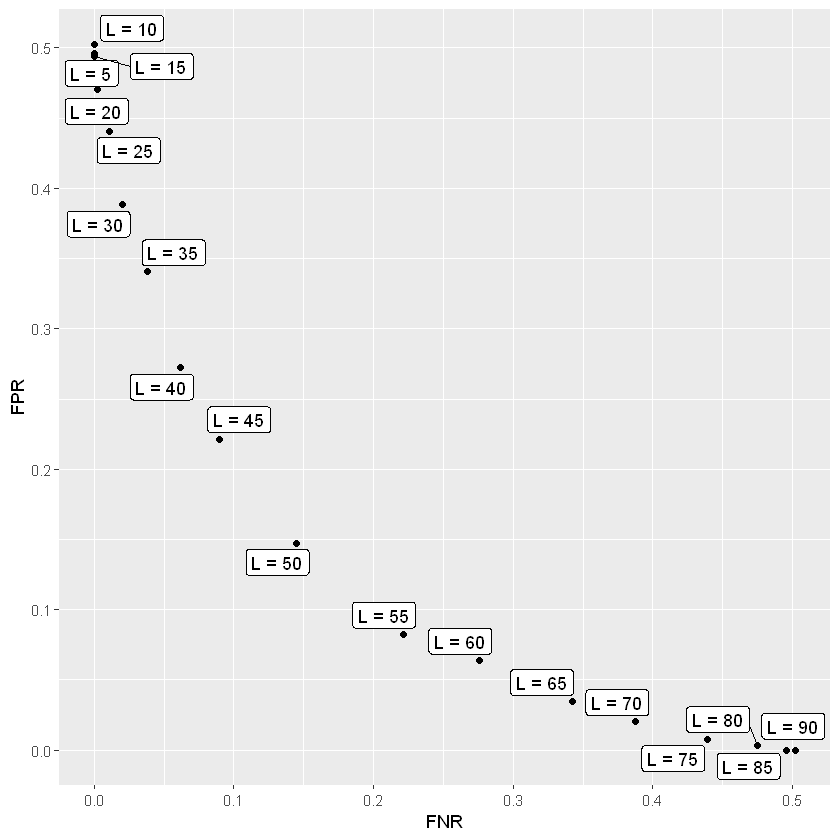

In [15]:
tradeoff <- evaluations_all[evaluations_all$Dataset == 'Test',c('FNR', 'FPR', "L")]
tradeoff <-aggregate(tradeoff, by=list(tradeoff$L), 
  FUN=mean, na.rm=TRUE)
tradeoff$label = paste("L = ", tradeoff$L, sep="") 
ggplot(data = tradeoff) + geom_point(aes(x = FNR, y = FPR, label = L)) + geom_label_repel(aes(x = FNR, y = FPR,label = label))

A plot like the above shows how FPR trades off with FNR -- if you want to decrease FNR, you must accept an increased FPR. Please be able to answer the following questions:

1. Suppose false positives are twice as costly to your company as false negatives. Which $L$ would you choose?
1. Suppose false positives are half as costly to your company as false negatives. Which $L$ would you choose?

### Accuracy as L changes

Finally, we can see how accuracy changes with $L$.

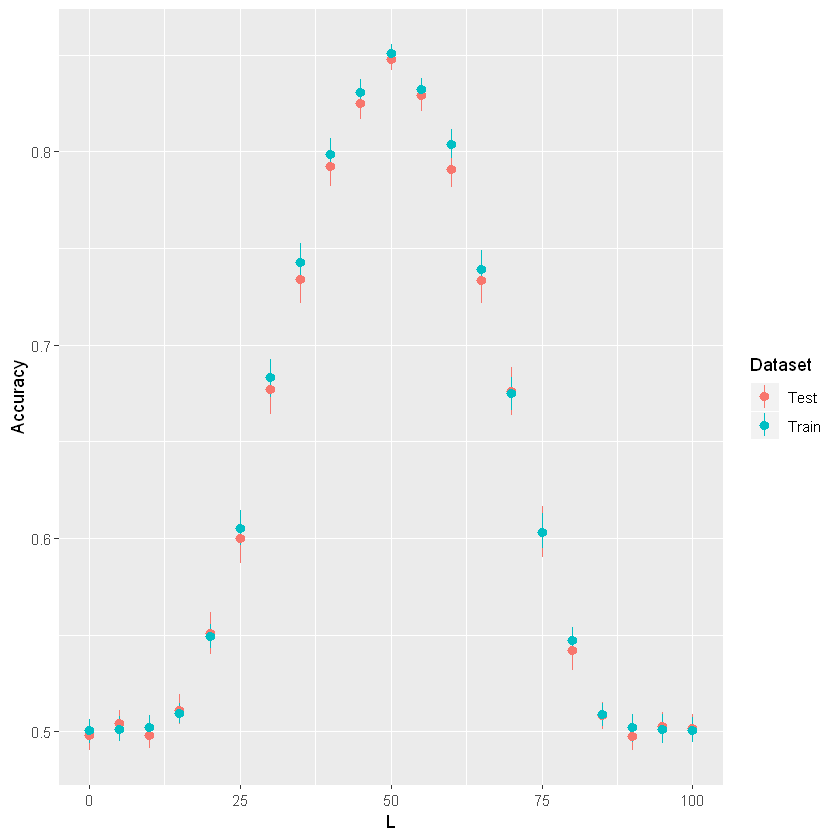

In [16]:
ggplot(data = evaluations_all) + stat_summary(fun.data=mean_cl_boot, geom="pointrange", aes(x = L, y = Accuracy, color = Dataset))

1. Why is accuracy maximized at $L = K/2 = 50$?